In [5]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from one_phase import one_phase
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# model to be studied
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

In [7]:
class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

Для начала возьмем $\tau / h^2$ = $ 400 $

In [8]:
Nx = 400
Nt = 20
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 1, 0.2e-1, model=model)
x0 = np.exp(-x)*np.cos(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]

In [9]:
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources([0.7], [-0.8])

In [10]:
nl_solver = newton()
solver_n.setSolver(nl_solver)

In [60]:
solver_n.setInitial(x0)
X, mes, t = test(solver_n, sample_size = 1)

test started
verdict : OK
mean time : 1.6293818950653076
mean newton iterations:  2.4


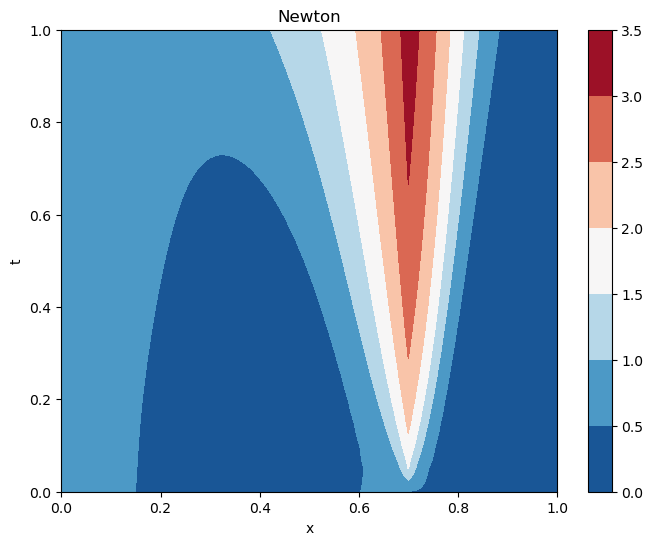

In [61]:
wp.show_res(solver_n)
plt.show()

In [85]:
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.7], [-0.8])
solver.setInitial(x0)

In [86]:
Nd = 5
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion)
solver.setSolver(nl_solver)

In [87]:
X, mes, t = test(solver, sample_size=1)

test started
verdict : OK
mean time : 5.275536060333252
mean aspen iterations:  2.85


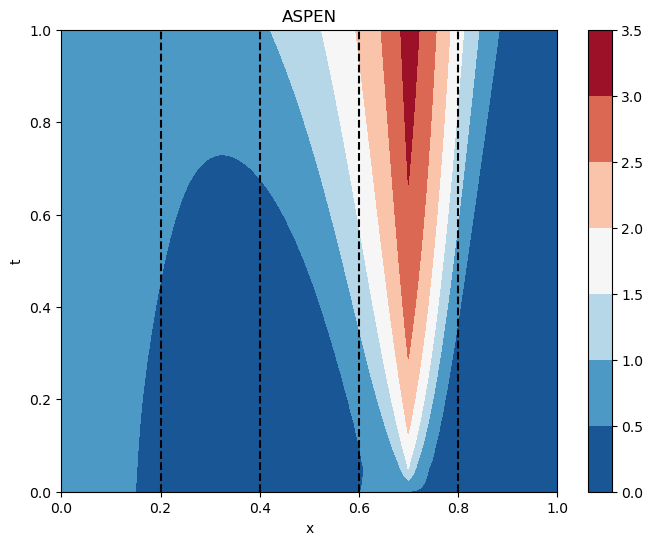

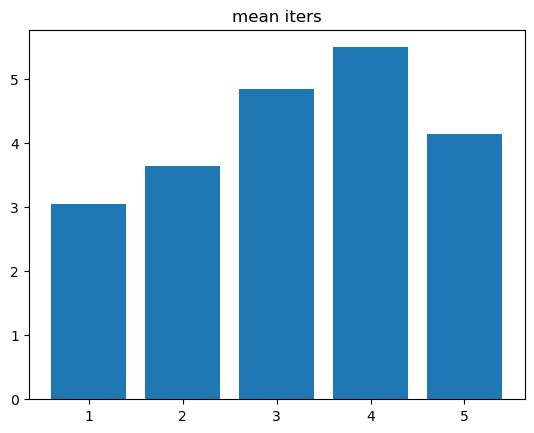

In [88]:
wp.show_res(solver, save='pic0')
wp.bar_loc(solver, Nd, save='pic1')

--time comparision--
newton : 1.6246931552886963
aspen : 5.234713077545166


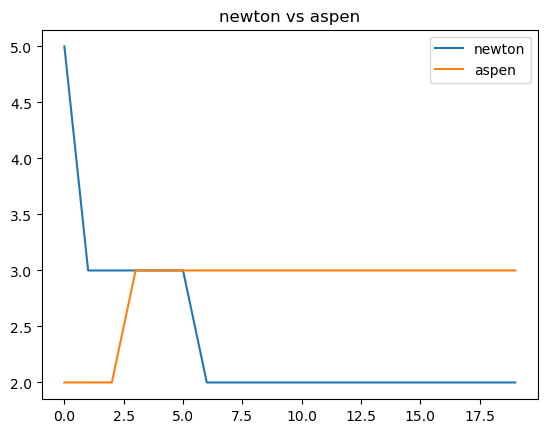

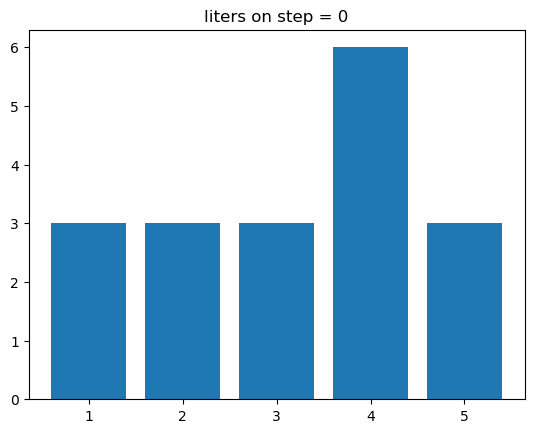

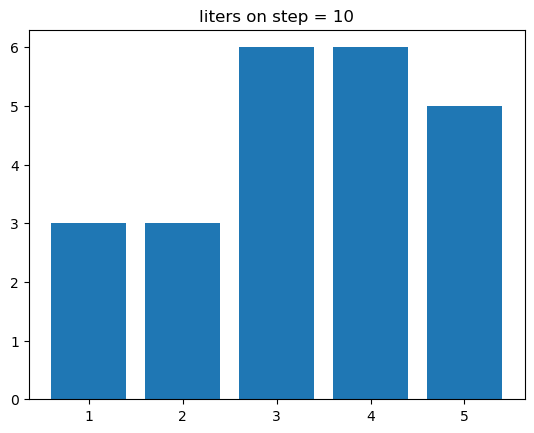

In [89]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp')
wp.bar_loc_step(solver, Nd, 0, save='step=0')
wp.bar_loc_step(solver, Nd, 10, save='step=10')

In [11]:
time = np.zeros((10, 2))

Nx = 1000
Nd = 5

x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 1, 0.2e-1, model=model)
x0 = np.exp(-x)*np.cos(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)

nl_new = newton()
partion = pt.partion_equally(Nx, Nd)
nl_asp = aspen(Nd, partion) 

for i in range(10):
    Nt = 20*(1+i)
    param ={'Nx': Nx, 'Nt' : Nt}
    prob = one_phase(D, param)
    solver = fxbd_1D(param, prob)
    solver.setBoundary(bd1, bd2)
    solver.setSources([0.7], [-0.8])
    solver.setInitial(x0)
    
    solver.setSolver(nl_new)
    _, mes, t = test(solver, sample_size=1)
    time[i, 0] = np.copy(t)
    if(mes != 'OK'):
        print(mes, i) 
        
    prob = one_phase(D, param)
    solver = fxbd_1D(param, prob)
    solver.setBoundary(bd1, bd2)
    solver.setSources([0.7], [-0.8])
    solver.setInitial(x0)
    solver.setSolver(nl_asp)
    _, mes, t = test(solver, sample_size=1)
    time[i, 1] = np.copy(t)
    if(mes != 'OK'):
        print(mes, i) 


test started
verdict : OK
mean time : 4.731800317764282
mean newton iterations:  2.45
test started
verdict : OK
mean time : 22.985077381134033
mean aspen iterations:  2.9
test started
verdict : OK
mean time : 14.894110679626465
mean newton iterations:  2.15
test started
verdict : OK
mean time : 37.66415214538574
mean aspen iterations:  2.525
test started
verdict : OK
mean time : 22.344732522964478
mean newton iterations:  2.0833333333333335
test started
verdict : OK
mean time : 47.531240940093994
mean aspen iterations:  2.1166666666666667
test started
verdict : OK
mean time : 33.12959885597229
mean newton iterations:  2.05
test started
verdict : OK
mean time : 69.39669013023376
mean aspen iterations:  2.0
test started
verdict : OK
mean time : 33.073872327804565
mean newton iterations:  1.97
test started
verdict : OK
mean time : 77.33107566833496
mean aspen iterations:  2.0
test started
verdict : OK
mean time : 43.58831596374512
mean newton iterations:  1.7583333333333333
test started
v

KeyboardInterrupt: 

[[  4.73180032  22.98507738]
 [ 14.89411068  37.66415215]
 [ 22.34473252  47.53124094]
 [ 33.12959886  69.39669013]
 [ 33.07387233  77.33107567]
 [ 43.58831596 100.95552969]
 [ 44.88691568 120.72941375]
 [ 52.99470139 127.32685971]
 [ 50.21576262 152.43736362]
 [ 52.92518854   0.        ]]


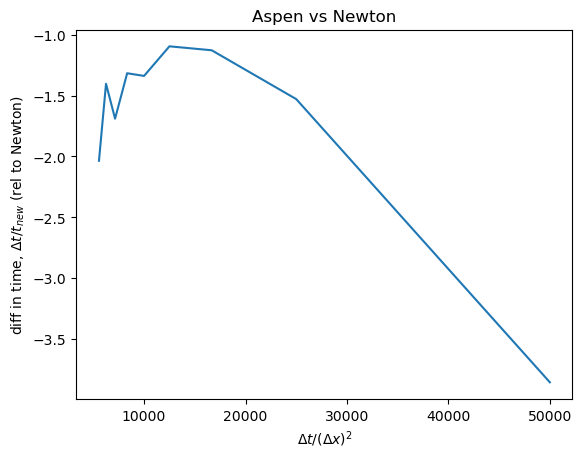

In [13]:
print(time)
dif = (+time[:-1, 0] - time[:-1, 1])/time[:-1, 0]
curant = Nx**2/(20*np.arange(1, 10))

plt.title('Aspen vs Newton')
plt.xlabel('$\Delta t/(\Delta x)^2$')
plt.ylabel('diff in time, $\Delta t /t_{new}$ (rel to Newton)')
plt.plot(curant, dif)
plt.savefig('comppp1', dpi = 300)
plt.show()